# Image Classification using MNIST and Fashion MNIST Data Set

### Description

[The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


In [16]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from keras.regularizers import l1, l2
from keras.optimizers import SGD, Adam

### Defining plotting functions

In [17]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['accuracy'], label = "training")
    ax2.plot(history.history['val_accuracy'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Data import and visualization

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

We'll use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively.

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.

In [18]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

Display some samples from MINST 


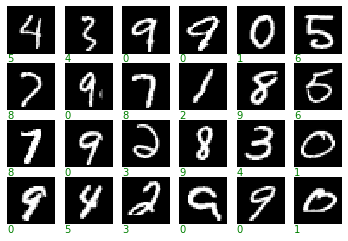

In [19]:
print("Display some samples from MINST ")
fig = plot_some_samples(x=x_train, y=y_train)
plt.savefig('E:\Coding\Image Classification\Figure\plt1.png')

Display some samples from Fashion-MINST 


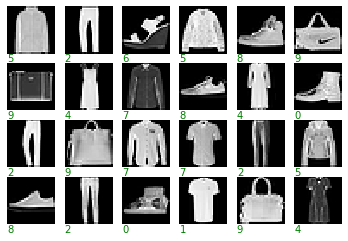

In [20]:
print("Display some samples from Fashion-MINST ")
fig = plot_some_samples(x=x_fashion_train, y=y_fashion_train)
plt.savefig('E:\Coding\Image Classification\Figure\plt2.png')

The green digits are mapped from given labels by +1.

**Data pre-processing**:      
To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).      
Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

1.One-hot-coding labels

In [21]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

2.flatten the input images

In [22]:
x_train_CNN = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)/np.max(x_train)
x_test_CNN = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)/np.max(x_test)

x_fashion_train_CNN = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1], x_fashion_train.shape[2], 1)/np.max(x_fashion_train)
x_fashion_test_CNN = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1], x_fashion_test.shape[2], 1)/np.max(x_fashion_test)

In [23]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## No hidden layer 

### Description

We define and fit a model without a hidden layer (since we will use multi-layer models later in this project, we can define a general constructor function for models with an arbitrary number of hidden layers already at this point).

1. We used the softmax activation for the output layer.
2. We used the categorical_crossentropy loss.
3. Added the accuracy metric to the metrics.
4. We choose stochastic gradient descent for the optimizer.
5. We choose a minibatch size of 128.
6. We fit for as many epochs as needed to see no further decrease in the validation loss.
7. We plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. We find the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`.
9. We repeat the above steps for fitting the network to the Fashion-MNIST dataset.

1. Defining the model

In [24]:
input_shape = (784, )
nb_classes = 10

model = Sequential()
model.add(Dense(nb_classes, input_shape = input_shape))
model.add(Activation('softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer = sgd,
              metrics=['accuracy'])

2. Setting the training parameters and fit the data

In [25]:
batch_size = 128
epochs = 60
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

3. Display the training history

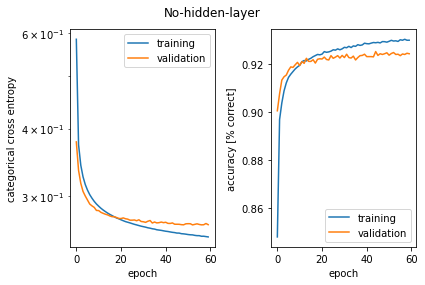

In [26]:
fig = plot_history(history, 'No-hidden-layer')
plt.savefig('E:\Coding\Image Classification\Figure\plt3.png')

4. Display the misclassified samples

In [27]:
yhat_test = np.argmax(model.predict(x_test), axis=1)
misclassified_inds = np.argwhere( yhat_test != np.argmax(y_test,axis=1)).flatten()

313/313 [==============================] - 1s 2ms/step


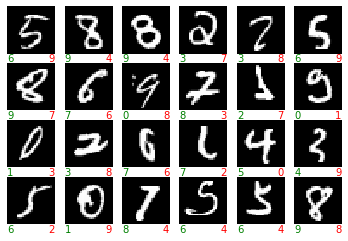

In [28]:
fig = plot_some_samples(x_test, y_test, yhat_test, misclassified_inds)
plt.savefig('E:\Coding\Image Classification\Figure\plt4.png')

The green digits are true labels plus 1 while the red digits are the corresponding predictions. 

5. We repeat all the steps for the fashion-minst data set

313/313 [==============================] - 1s 2ms/step


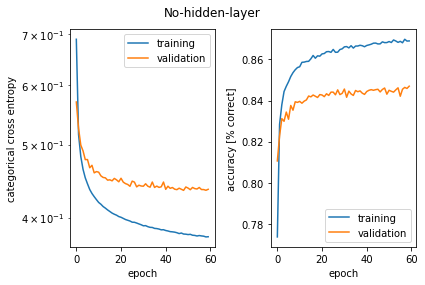

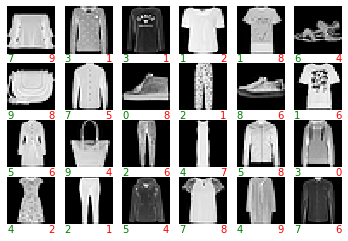

In [29]:
# 1. We define the model
input_shape = (784, )
nb_classes = 10

model = Sequential()
model.add(Dense(nb_classes, input_shape = input_shape))
model.add(Activation('softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer = sgd,
              metrics=['accuracy'])

# 2.Setting the training parameters and fit the data
batch_size = 128
epochs = 60
history = model.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_fashion_test, y_fashion_test))
score = model.evaluate(x_fashion_test, y_fashion_test, verbose=0)

# 3. Displaing the training history
fig = plot_history(history, 'No-hidden-layer')
plt.savefig('E:\Coding\Image Classification\Figure\plt5.png')

# 4. Displaing the misclassified samples
yhat_test = np.argmax(model.predict(x_test), axis=1)
misclassified_inds = np.argwhere( yhat_test != np.argmax(y_fashion_test,axis=1)).flatten()
fig = plot_some_samples(x_fashion_test, y_fashion_test, yhat_test, misclassified_inds)
plt.savefig('E:\Coding\Image Classification\Figure\plt6.png')

## One hidden layer, different optizimizers & overfitting

We train a network with one hidden layer and compare different optimizers.

1. We use one hidden layer with 128 units and the 'relu' activation.
2. We fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD).
3. Replaced the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plotted the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure.
5. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above.

**We use one hidden layer with 128 units and the 'relu' activation to fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD).**

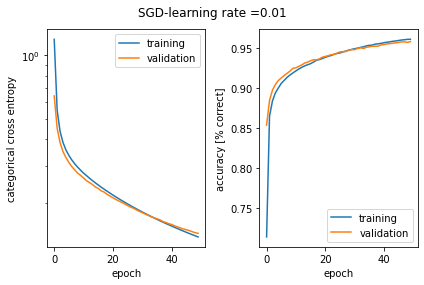

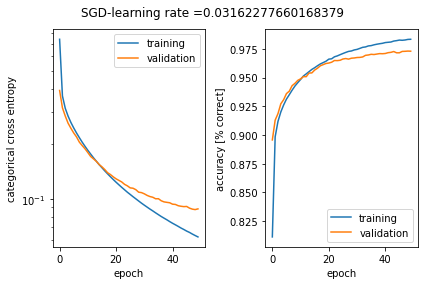

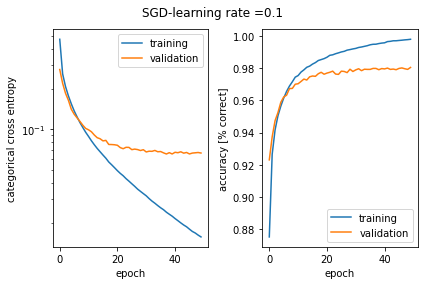

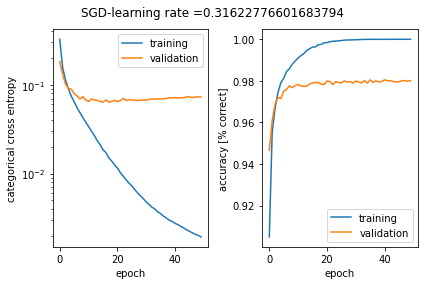

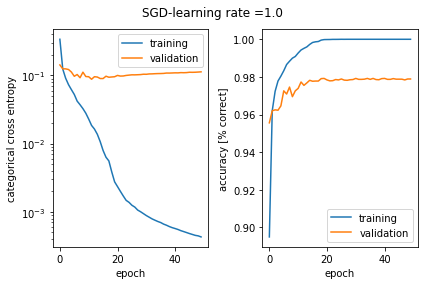

In [34]:
for learning_rate in np.logspace(-2, 0, 5):
    
    model1 = Sequential()
    model1.add(Dense(units=128, activation='relu',input_shape=input_shape))
    model1.add(Dense(units=nb_classes, activation='softmax'))

    model1.compile(loss='categorical_crossentropy',
                      optimizer=SGD(learning_rate = learning_rate),
                      metrics=['accuracy'])

    history = model1.fit(x_train, y_train,
                           batch_size = 128,
                           epochs = 50, 
                           verbose = 0,
                           validation_data=(x_test, y_test))

    fig = plot_history(history, 'SGD-learning rate ='+ str(learning_rate))
    plt.savefig('E:\Coding\Image Classification\Figure\plt{learning_rate}.png'.format(learning_rate=learning_rate))

Viewing from the figures above, we can find that:
1. The smaller of the learning rate, the slower of convergence. 
2. A large learning rate counld lead to overfitting -- validation errors could slightly increase after around 5-8 epoch.

**Now we replace the stochastic gradient descent optimizer with the Adam optimizer**

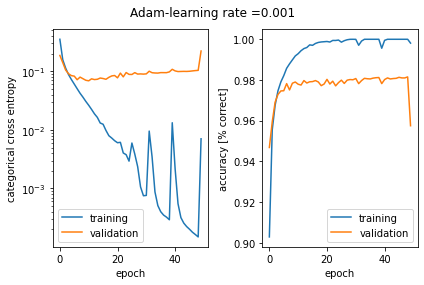

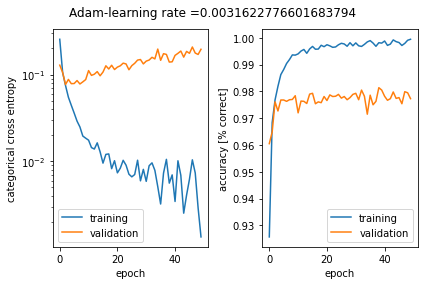

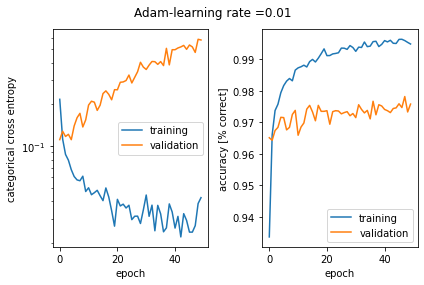

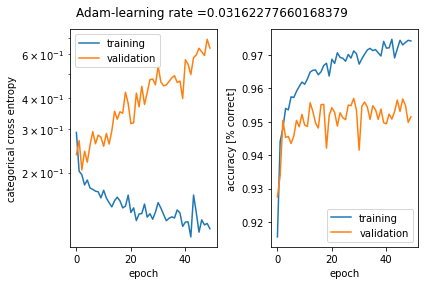

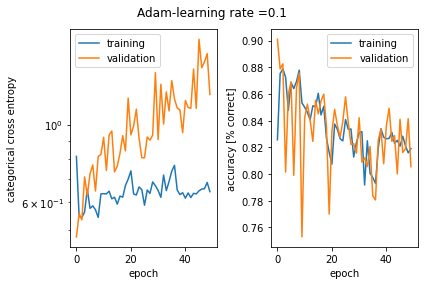

In [35]:
for learning_rate in np.logspace(-3, -1, 5):
    
    model2 = Sequential()
    model2.add(Dense(units=128, activation='relu',input_shape=input_shape))
    model2.add(Dense(units=nb_classes, activation='softmax'))

    model2.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate = learning_rate),
                      metrics=['accuracy'])

    history = model2.fit(x_train, y_train,
                           batch_size = 128,
                           epochs = 50, 
                           verbose = 0,
                           validation_data=(x_test, y_test))

    fig = plot_history(history, 'Adam-learning rate ='+ str(learning_rate))
    plt.savefig('E:\Coding\Image Classification\Figure\plt0{learning_rate}.png'.format(learning_rate = learning_rate))

Viewing from the figures above, we can find that:
1. Adam prefers smaller learning rates than sgd.
2. A large learning rate counld lead to a strong overfitting after around 5 epoch.

**We plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure.**

In [36]:
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['accuracy'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_accuracy'], label=label1 + ' validation')
    ax2.plot(history_adam.history['accuracy'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_accuracy'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

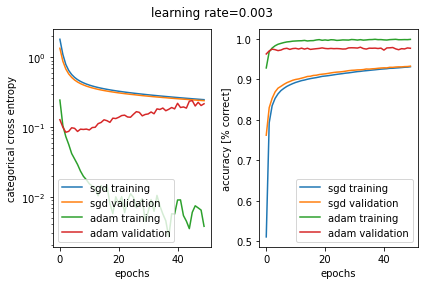

In [38]:
learning_rate = 0.003
model30 = Sequential()
model30.add(Dense(units=128, activation='relu',input_shape=input_shape))
model30.add(Dense(units=nb_classes, activation='softmax'))
model30.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=['accuracy'])
adam = model30.fit(x_train, y_train,
                       batch_size = 128,
                       epochs = 50, 
                       verbose = 0,
                       validation_data=(x_test, y_test))

model31 = Sequential()
model31.add(Dense(units=128, activation='relu',input_shape=input_shape))
model31.add(Dense(units=nb_classes, activation='softmax'))

model31.compile(loss='categorical_crossentropy',
                  optimizer=SGD(learning_rate = learning_rate),
                  metrics=['accuracy'])
sgd = model31.fit(x_train, y_train,
                       batch_size = 128,
                       epochs = 50, 
                       verbose = 0,
                       validation_data=(x_test, y_test))

fig = comparison_plot(sgd, adam, 'sgd', 'adam', 'learning rate='+str(learning_rate))
plt.savefig('E:\Coding\Image Classification\Figure\plt7.png')

A)When learning rate = 0.3, sdg converges quickly but then it overfits the training data

B)When learning rate = 0.01, sdg converges slowly.

It shows that at around 5-8 epochs the Adam starts to overfit.

When a model begin to overfit training data, the loss curve of testing data will begin to raise and the accuracy cureve of testing data will begin to viberate and decrease.

**We run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above.**

Since we use a small learning rate (0.003), in order to train the network throughly, the 'epoch' is set to be 150.

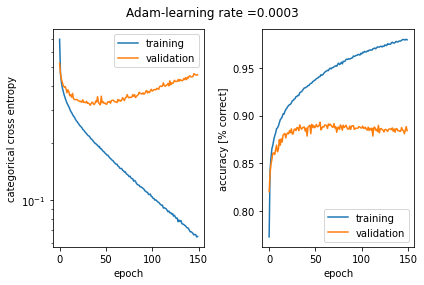

In [39]:
learning_rate = 3e-4
model4 = Sequential()
model4.add(Dense(units=128, activation='relu',input_shape=input_shape))
model4.add(Dense(units=nb_classes, activation='softmax'))
model4.compile(loss='categorical_crossentropy',
                  optimizer = Adam(learning_rate = learning_rate),
                  metrics = ['accuracy'])
adam = model4.fit(x_fashion_train, y_fashion_train,
                       batch_size = 128,
                       epochs = 150, 
                       verbose = 0,
                       validation_data=(x_fashion_test, y_fashion_test))

fig = plot_history(adam, 'Adam-learning rate ='+ str(learning_rate))
plt.savefig('E:\Coding\Image Classification\Figure\plt8.png')

In Fashion-MNIST dataset, the network does not perform as well as in MNIST.      
This could be because Fashion-MNIST is more difficult than MNIST. 

## Model performance as a function of number of hidden neurons

Investigating how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fitting a reasonable number of models with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset.   
2. Then we plot the best validation loss and accuracy versus the number of hidden neurons. 
3. We repeat steps 1. & 2. for the Fashion-MNIST dataset. 

In this part we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds.

In [33]:
def hidden_layer(hidden_neurons, hidden_layer_size, 
                 learning_rate, optimizer, 
                 bn, dropout, reg, epochs, verbose,
                 x_train, y_train, x_test, y_test, reg_value = 1e-6):
    input_shape = (784, )
    nb_classes = 10
    batch_size = 128

    model = Sequential()
    
    # First hidden layer
    model.add(Dense(hidden_neurons, input_shape = input_shape))
    
    if(bn == True):
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if(dropout == True):
        model.add(Dropout(0.25))

    # Second and third hidden layer
    if(hidden_layer_size > 1):
        for i in range(hidden_layer_size - 1):
            model.add(Dense(50))
            if(bn == True):
                model.add(BatchNormalization())   
            model.add(Activation('relu'))
            if(dropout == True):
                model.add(Dropout(0.25))
 
    # Output layer
    if reg == 'l1':
        model.add(Dense(nb_classes, kernel_regularizer = l1(reg_value)))
    elif reg == 'l2':
        model.add(Dense(nb_classes, kernel_regularizer = l2(reg_value)))
    else:
        model.add(Dense(nb_classes))        
    model.add(Activation('softmax' ))

    if(optimizer == 'sgd'):
        optimizer = SGD(lr = learning_rate)
    else:
        optimizer = Adam(lr = learning_rate) 
        
    model.compile(loss ='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = verbose,
                    validation_data = (x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose = 0)
    model.summary()
    return history

**1.Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)**

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 10)                7850      
                                                                 
 activation_3 (Activation)   (None, 10)                0         
                                                                 
 dense_40 (Dense)            (None, 10)                110       
                                                                 
 activation_4 (Activation)   (None, 10)                0         
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)           

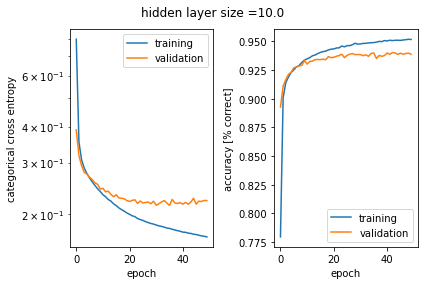

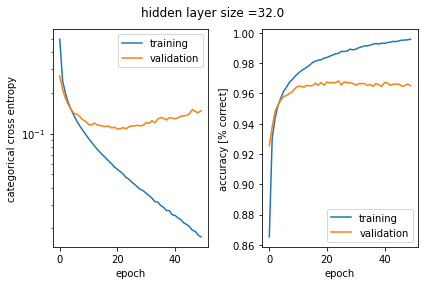

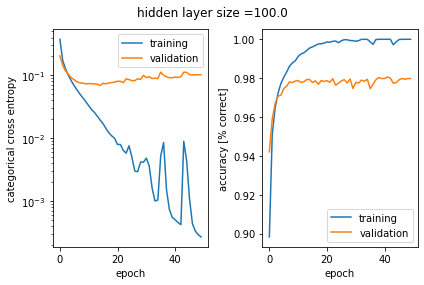

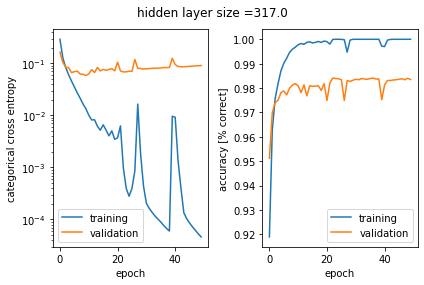

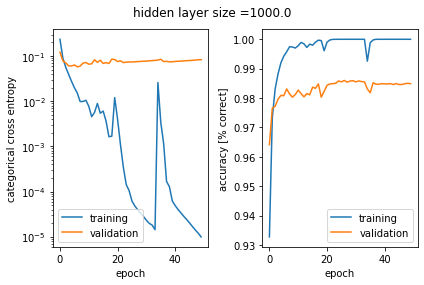

In [34]:
history_size = []
for number_of_neuron in np.ceil(np.logspace(1, 3, 5)):
    history = hidden_layer(hidden_neurons = int(number_of_neuron), hidden_layer_size = 1,
                           learning_rate = 0.001, optimizer = 'adam', 
                           bn = False, dropout = False, reg = False, epochs = 50, verbose = 0,
                           x_train = x_train, x_test = x_test, y_train = y_train, y_test = y_test)
    history_size.append(history)
    fig = plot_history(history, 'hidden layer size ='+ str(number_of_neuron))

**We plot the best validation loss and accuracy versus the number of hidden neurons.**

In [36]:
lowest_loss = [min(x.history['val_loss']) for x in history_size]
highest_acc = [min(x.history['accuracy']) for x in history_size]

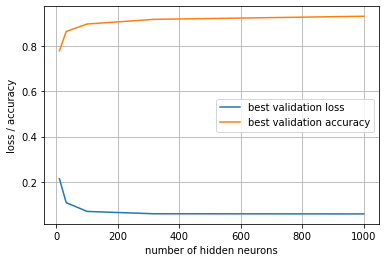

In [37]:
plt.plot(np.ceil(np.logspace(1, 3, 5)),lowest_loss, np.ceil(np.logspace(1, 3, 5)), highest_acc )
plt.grid()
plt.xlabel('number of hidden neurons')
plt.ylabel('loss / accuracy')
plt.legend(['best validation loss', 'best validation accuracy'])

This experiment shows that the more hidden neurons the network contains the better performance it has which is consistent with the general approximation theorem that "a feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of R^n, under mild assumptions on the activation function".

## Going deeper: tricks and regularization

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

1. No batch normalization, no dropout layers and regularizations

c:\Users\LENOVO\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 50)                39250     
                                                                 
 activation_13 (Activation)  (None, 50)                0         
                                                                 
 dense_50 (Dense)            (None, 50)                2550      
                                                                 
 activation_14 (Activation)  (None, 50)                0         
                                                                 
 dense_51 (Dense)            (None, 50)                2550      
                                                                 
 activation_15 (Activation)  (None, 50)                0         
                                                                 
 dense_52 (Dense)            (None, 10)              

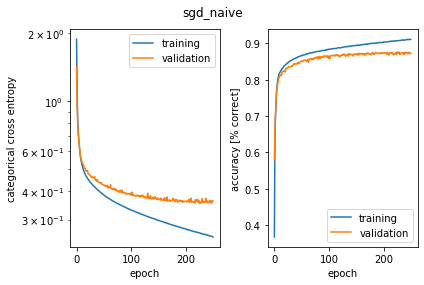

In [38]:
sgd_navie = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                   learning_rate = 0.003, optimizer = 'sgd', 
                   bn = False, dropout = False, reg = False, epochs = 250, verbose = 0,
                   x_train = x_fashion_train, x_test = x_fashion_test, y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(sgd_navie, 'sgd_naive')

2. Only batch match

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 50)                39250     
                                                                 
 batch_normalization (BatchN  (None, 50)               200       
 ormalization)                                                   
                                                                 
 activation_17 (Activation)  (None, 50)                0         
                                                                 
 dense_54 (Dense)            (None, 50)                2550      
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 activation_18 (Activation)  (None, 50)              

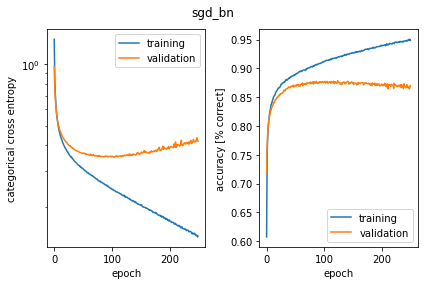

In [39]:
sgd_bn = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                   learning_rate = 0.003, optimizer = 'sgd', 
                   bn = True, dropout = False, reg = False, epochs = 250, verbose = 0,
                   x_train = x_fashion_train, x_test = x_fashion_test, y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(sgd_bn, 'sgd_bn')

After adding batch normalization layer, the network converges faster and quickly overfits the training data as batch normalization guarantees that all inputs will explore both the linear and nonlinear part of the activation function.

3. Only dropout layers

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 50)                39250     
                                                                 
 activation_21 (Activation)  (None, 50)                0         
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_58 (Dense)            (None, 50)                2550      
                                                                 
 activation_22 (Activation)  (None, 50)                0         
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_59 (Dense)            (None, 50)              

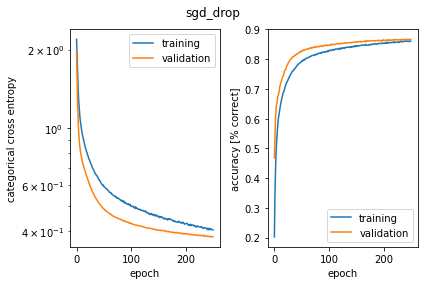

In [40]:
sgd_drop = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                   learning_rate = 0.003, optimizer = 'sgd', 
                   bn = False, dropout = True, reg = False, epochs = 250, verbose = 0,
                   x_train = x_fashion_train, x_test = x_fashion_test, y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(sgd_drop, 'sgd_drop')

As training a dropout network is equal to training several models at the same time (like bagging), after appending dropout layers, the network converges slower. But since the dropout method enforces representation sharing, it makes the network more robust so the learning curves become more smooth. 

4. Only l1 regularization terms

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 50)                39250     
                                                                 
 activation_25 (Activation)  (None, 50)                0         
                                                                 
 dense_62 (Dense)            (None, 50)                2550      
                                                                 
 activation_26 (Activation)  (None, 50)                0         
                                                                 
 dense_63 (Dense)            (None, 50)                2550      
                                                                 
 activation_27 (Activation)  (None, 50)                0         
                                                                 
 dense_64 (Dense)            (None, 10)              

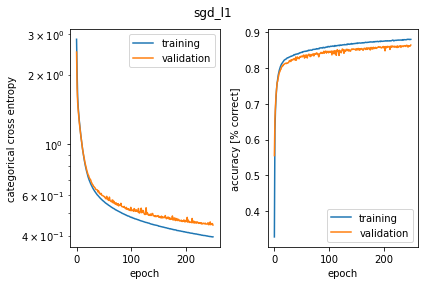

In [41]:
sgd_l1 = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                     learning_rate = 0.003, optimizer = 'sgd', 
                     bn = False, dropout = False, reg = 'l1', 
                     epochs = 250, verbose = 0,
                     x_train = x_fashion_train, x_test = x_fashion_test, 
                     y_train = y_fashion_train, y_test = y_fashion_test,
                     reg_value = 0.01)
fig = plot_history(sgd_l1, 'sgd_l1')

5. Only l2 regularizaiton terms

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 50)                39250     
                                                                 
 activation_29 (Activation)  (None, 50)                0         
                                                                 
 dense_66 (Dense)            (None, 50)                2550      
                                                                 
 activation_30 (Activation)  (None, 50)                0         
                                                                 
 dense_67 (Dense)            (None, 50)                2550      
                                                                 
 activation_31 (Activation)  (None, 50)                0         
                                                                 
 dense_68 (Dense)            (None, 10)              

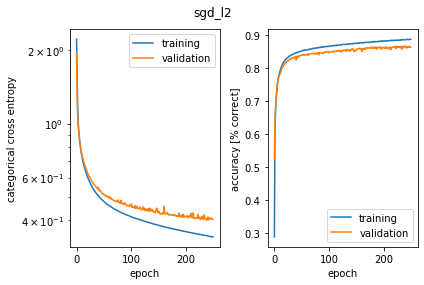

In [42]:
sgd_l2 = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                      learning_rate = 0.003, optimizer = 'sgd', 
                      bn = False, dropout = False, reg = 'l2', 
                      epochs = 250, verbose = 0,
                      x_train = x_fashion_train, x_test = x_fashion_test, 
                      y_train = y_fashion_train, y_test = y_fashion_test,
                      reg_value = 0.01)
fig = plot_history(sgd_l2, 'sgd_l2')

6. Batch normalization + dropout layers + regularizations

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 50)                39250     
                                                                 
 batch_normalization_3 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 activation_33 (Activation)  (None, 50)                0         
                                                                 
 dense_70 (Dense)            (None, 50)                2550      
                                                                 
 batch_normalization_4 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 activation_34 (Activation)  (None, 50)              

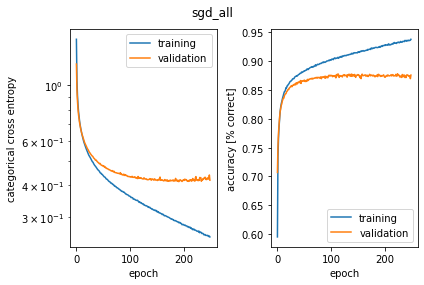

In [43]:
sgd_tuned = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                       learning_rate = 0.003, optimizer = 'sgd', 
                       bn = True, dropout = False, reg = 'l2',
                       epochs = 250, verbose = 0,
                       x_train = x_fashion_train, x_test = x_fashion_test, 
                       y_train = y_fashion_train, y_test = y_fashion_test,
                       reg_value = 0.01)
fig = plot_history(sgd_tuned, 'sgd_all')

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 50)                39250     
                                                                 
 batch_normalization_6 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 activation_37 (Activation)  (None, 50)                0         
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_74 (Dense)            (None, 50)                2550      
                                                                 
 batch_normalization_7 (Batc  (None, 50)               200       
 hNormalization)                                     

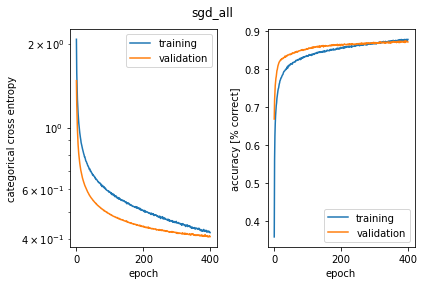

In [44]:
sgd_tuned = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                       learning_rate = 0.003, optimizer = 'sgd', 
                       bn = True, dropout = True, reg = 'l2',
                       epochs = 400, verbose = 0,
                       x_train = x_fashion_train, x_test = x_fashion_test, 
                       y_train = y_fashion_train, y_test = y_fashion_test,
                       reg_value = 0.01)
fig = plot_history(sgd_tuned, 'sgd_all')

After we have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot.

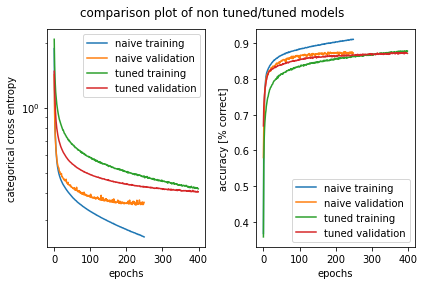

In [45]:
fig = comparison_plot(sgd_navie, sgd_tuned, 'naive', 'tuned', 'comparison plot of non tuned/tuned models')

Viewing from the two figures above, we can find that the tunned model converges at around 50 epoches while the naive model converges at around 200 epoches. In addition, the naive model can not perform as good as the tunned one until 210 epoches. 

Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves.

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 50)                39250     
                                                                 
 batch_normalization_9 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 activation_41 (Activation)  (None, 50)                0         
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_78 (Dense)            (None, 50)                2550      
                                                                 
 batch_normalization_10 (Bat  (None, 50)               200       
 chNormalization)                                    

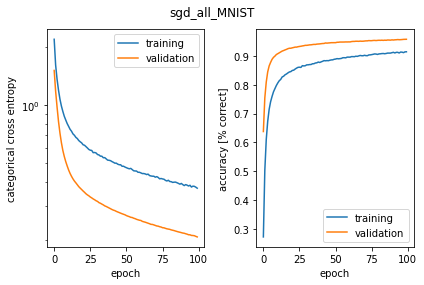

In [46]:
sgd_tuned_MNIST = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                       learning_rate = 0.003, optimizer = 'sgd', 
                       bn = True, dropout = True, reg = 'l2',
                       epochs = 100, verbose = 0,
                       x_train = x_train, x_test = x_test, 
                       y_train = y_train, y_test = y_test,
                       reg_value = 0.005)
fig = plot_history(sgd_tuned_MNIST, 'sgd_all_MNIST')

## Convolutional neural networks (CNNs)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters.
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST.
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets?

Here we accomplish a function which can generate a CNN according to the given parameters and architectures.

In [47]:
def CNN(bn, activation, hidden_layer, filter_size, learning_rate, epochs, verbose, x_train, x_test, y_train, y_test):
    pool_size = (2,2)
    reg = 0.01
    input_shape = (28, 28, 1)
    nb_classes = 10
    batch_size = 128
 
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape = input_shape))
    if(bn == True):
        model.add(BatchNormalization())
    if(activation == 'relu'):
        model.add(Activation('relu'))
    else:
        model.add(Activation('sigmoid'))
    model.add(MaxPooling2D(pool_size=pool_size, padding = 'same'))
    
    if(hidden_layer == True):
        model.add(Conv2D(filter_size, 5, padding='same'))
        if(bn == True):
            model.add(BatchNormalization())
        if(activation == 'relu'):
            model.add(Activation('relu'))
        else:
            model.add(Activation('sigmoid'))
        model.add(MaxPooling2D(pool_size=pool_size, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=l2(reg))) # Fully connected layer (128 neurons)
    if(bn == True):
        model.add(BatchNormalization())
    if(activation == 'relu'):
        model.add(Activation('relu'))
    else:
        model.add(Activation('sigmoid'))
    
    model.add(Dense(nb_classes, kernel_regularizer=l2(reg)))
    if(bn == True):
        model.add(BatchNormalization())
    model.add(Activation('softmax')) 
    optimizer = Adam(lr = learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(x_train, y_train,
                batch_size = batch_size,
                epochs = epochs,
                verbose = verbose,
                validation_data = (x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose = verbose)
    return history

In the following, we will run MNIST and Fashion MNIST under different architectures (filter sizes), and plot their learning rate to compare the performance.

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 activation_61 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 dense_91 (Dense)            (None, 128)               802944    
                                                                 
 activation_62 (Activation)  (None, 128)               0         
                                                     

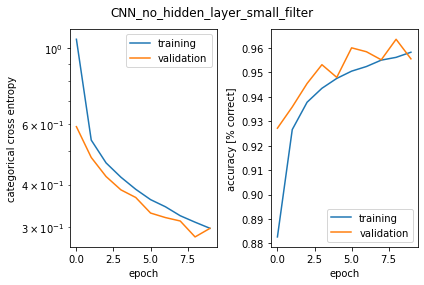

In [54]:
CNN_no_hidden_layer_small_filter = CNN(bn = False, activation = 'relu', hidden_layer = False, filter_size = 32, learning_rate = 3e-4, epochs = 10, verbose = 0,
                          x_train = x_train_CNN, x_test = x_test_CNN, 
                          y_train = y_train, y_test = y_test)
fig = plot_history(CNN_no_hidden_layer_small_filter, 'CNN_no_hidden_layer_small_filter')

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 activation_64 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dense_93 (Dense)            (None, 128)               802944    
                                                                 
 activation_65 (Activation)  (None, 128)               0         
                                                     

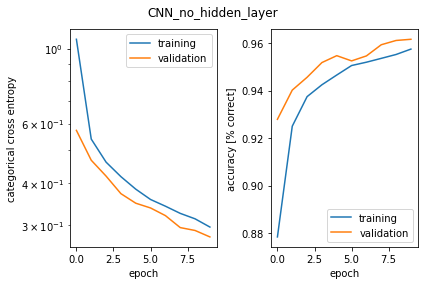

In [55]:
CNN_no_hidden_layer = CNN(bn = False, activation = 'relu', hidden_layer = False, filter_size = 64, learning_rate = 3e-4, epochs = 10, verbose = 0,
                          x_train = x_train_CNN, x_test = x_test_CNN, 
                          y_train = y_train, y_test = y_test)
fig = plot_history(CNN_no_hidden_layer, 'CNN_no_hidden_layer')

We can see that bigger filter size will increase the accuracy. Hence, in the following we will use filter_size 64.

Below we run MNIST and Fashion MNIST with/out hidden layer and under different parameters including learning rate and epoches.

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 activation_71 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 activation_72 (Activation)  (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

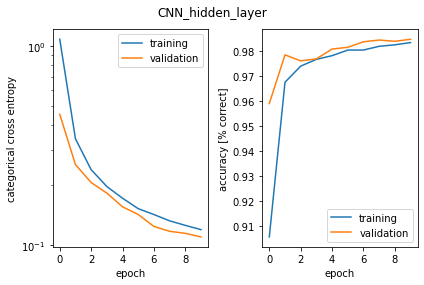

In [57]:
CNN_hidden_layer = CNN(bn = False, activation = 'relu', hidden_layer = True, filter_size = 64, learning_rate = 3e-4, epochs = 10, verbose = 0,
                       x_train = x_train_CNN, x_test = x_test_CNN, 
                       y_train = y_train, y_test = y_test)
fig = plot_history(CNN_hidden_layer, 'CNN_hidden_layer')

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 activation_75 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 6272)              0         
                                                                 
 dense_99 (Dense)            (None, 128)               802944    
                                                                 
 activation_76 (Activation)  (None, 128)               0         
                                                     

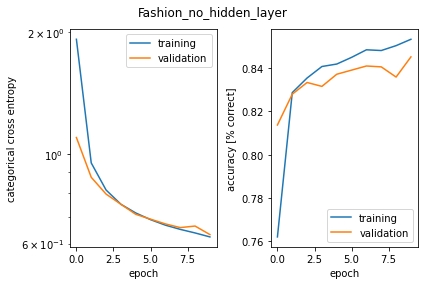

In [58]:
Fashion_no_hidden_layer = CNN(bn = False, activation = 'relu', hidden_layer = False, filter_size = 64, learning_rate = 1e-4, epochs = 10, verbose = 0,
                          x_train = x_fashion_train_CNN, x_test = x_fashion_test_CNN, 
                          y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(Fashion_no_hidden_layer, 'Fashion_no_hidden_layer')

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 activation_78 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 activation_79 (Activation)  (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

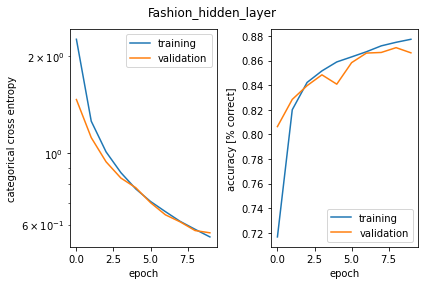

In [59]:
Fashion_hidden_layer = CNN(bn = False, activation = 'relu', hidden_layer = True, filter_size = 64, learning_rate = 1e-4, epochs = 10, verbose = 0,
                          x_train = x_fashion_train_CNN, x_test = x_fashion_test_CNN, 
                          y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(Fashion_hidden_layer, 'Fashion_hidden_layer')

We can see that the accuracies are increased after we add one more CNN hidden layer under both MNIST and Fashion MNIST datasets.

In the previous exercise, we get that MNIST and Fashion MNIST can achieve accuracy around 0.9 and 0.8 on validation set using fully-connected architecture. In this exercise, we get that MNIST and Fashion MNIST can achieve accuracy around 0.98 and 0.9 on validation set using CNN architecture. It is obvious that CNN architecture improves the performance on both datasets. 

## Sigmoidal activation function and batch-normalization

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe?
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise?

**Training without batch normalization**
1. On MNIST

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 activation_82 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 activation_83 (Activation)  (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

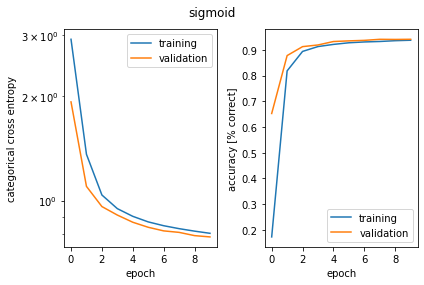

In [60]:
sigmoid = CNN(bn = False, activation = 'sigmoid', hidden_layer = True, filter_size = 64, learning_rate = 3e-4, epochs = 10, verbose = 0,
                          x_train = x_train_CNN, x_test = x_test_CNN, 
                          y_train = y_train, y_test = y_test)
fig = plot_history(sigmoid, 'sigmoid')

2. On Fashion-MNIST

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 activation_86 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 activation_87 (Activation)  (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

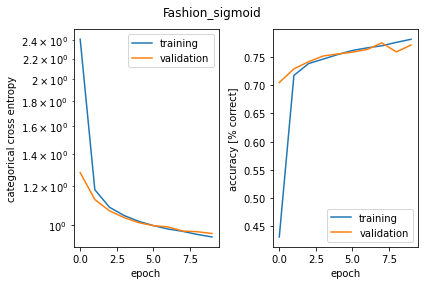

In [61]:
Fashion_sigmoid = CNN(bn = False, activation = 'sigmoid', hidden_layer = True, filter_size = 64, learning_rate = 3e-4, epochs = 10, verbose = 0,
                          x_train = x_fashion_train_CNN, x_test = x_fashion_test_CNN, 
                          y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(Fashion_sigmoid, 'Fashion_sigmoid')

**Training with batch normalization**
1. On MNIST

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_16 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 activation_90 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 batch_normalization_17 (Bat  (None, 14, 14, 64)     

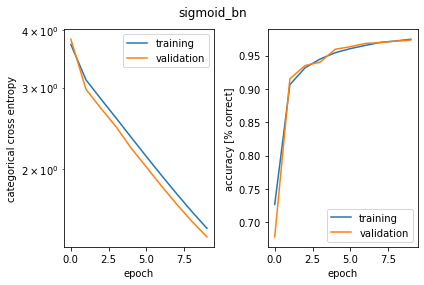

In [62]:
sigmoid_bn = CNN(bn = True, activation = 'sigmoid', hidden_layer = True, filter_size = 64, learning_rate = 1e-5, epochs = 10, verbose = 0,
                          x_train = x_train_CNN, x_test = x_test_CNN, 
                          y_train = y_train, y_test = y_test)
fig = plot_history(sigmoid_bn, 'sigmoid_bn')

Comparing to the model without batch normalization, we can see that the accuracy on MNIST is not improved much. It is because MNIST is relatively easy. But as we can see below, on Fashion-MNIST, using batch normalization will bring an obvious improvement on accuracy.

2. On Fashion-MNIST

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_20 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 activation_94 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 batch_normalization_21 (Bat  (None, 14, 14, 64)     

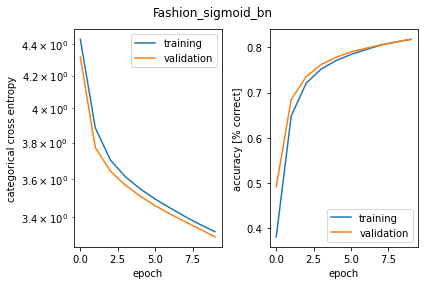

In [63]:
Fashion_sigmoid_bn = CNN(bn = True, activation = 'sigmoid', hidden_layer = True, filter_size = 64, learning_rate = 1e-6, epochs = 10, verbose = 0,
                          x_train = x_fashion_train_CNN, x_test = x_fashion_test_CNN, 
                          y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(Fashion_sigmoid_bn, 'Fashion_sigmoid_bn')

Using Sigmoid as activation leads to lower accuracy.

After implementing batch normalization, the performace is improved. 

---